In [2]:
%load_ext autoreload


import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.insert(0,"/home/jorgenem/gitrepos/oslo_method_python")
import oslo_method_python as om
import copy
%autoreload 2


import matplotlib as mpl
#mpl.style.use('article')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
rc('errorbar', capsize=1.5) # Set error bar style


%matplotlib notebook


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


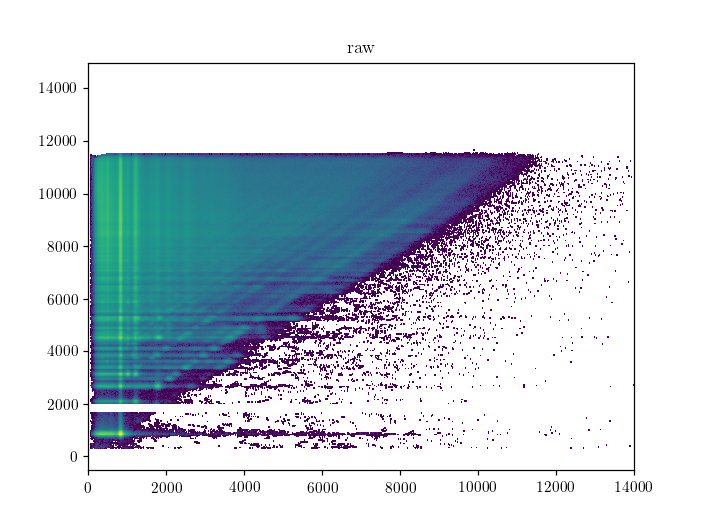

In [3]:
# Import raw matrix into instance of om.Matrix() and plot it
fname_raw = "data/Fe56-alfna_no_el_no_si.m"
raw = om.Matrix()
raw.load(fname_raw)
raw.plot(title="raw", zscale="log")

<IPython.core.display.Javascript object>


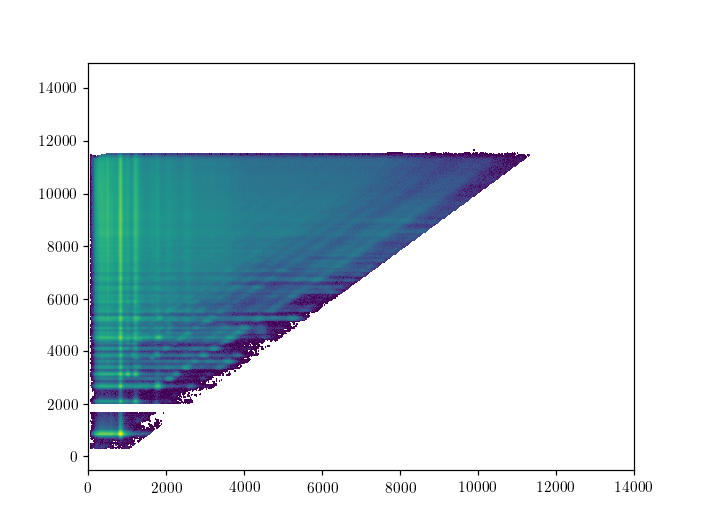

In [4]:
# Cut away diagonal
Ex1 = 0
Eg1 = 800
E1 = [Ex1, Eg1]
Ex2 = 7300
Eg2 = 7500
E2 = [Ex2, Eg2]
#raw_diagcut = copy.copy(raw)
#raw_diagcut.matrix = om.cut_diagonal(raw.matrix, raw.E0_array, raw.E1_array, E1, E2)
raw.cut_diagonal(E1, E2)
raw.plot(zscale="log")

<IPython.core.display.Javascript object>


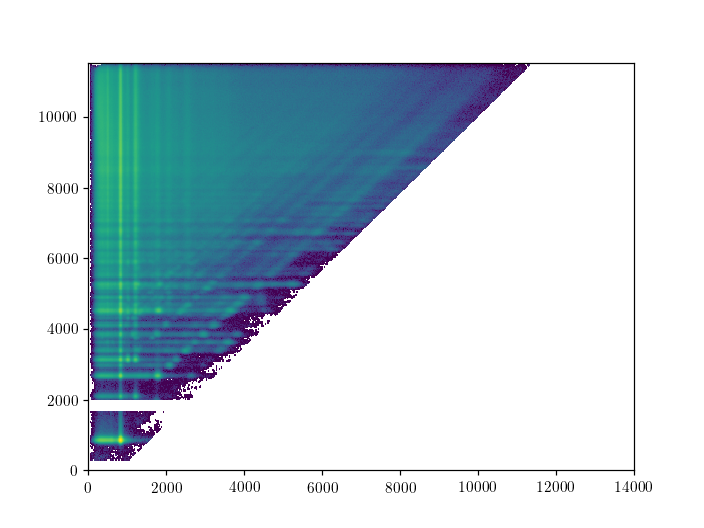

In [5]:
# Drop Ex larger than Sn, about 11500 keV
raw.cut_rect(axis=0, E_limits=[0, 11500])
raw.plot()

raw.calibration() = {'a00': 11.5, 'a01': 31.0, 'a10': -3.5, 'a11': 7.0}
raw_rebinned.calibration() = {'a00': 11.5, 'a01': 31.0, 'a10': -3.5, 'a11': 20.0}
new midbin calibration Eg: a0 = 6.500000, a1 = 20.000000


<IPython.core.display.Javascript object>


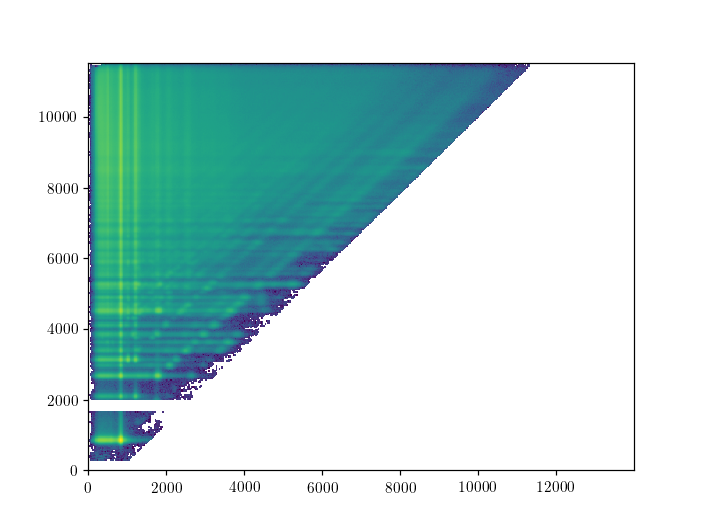

In [6]:
# Rebin Eg axis to get more handleable sizes
print("raw.calibration() =", raw.calibration())

a_Eg_out = 20 # keV
Eg_array_out = om.E_array_from_calibration(raw.calibration()["a10"],
                                           a_Eg_out,
                                           E_max=raw.E1_array.max())

raw_matrix_rebinned = om.rebin_matrix(raw.matrix,
                                  E_array_in=raw.E1_array,
                                  E_array_out=Eg_array_out,
                                  rebin_axis=1)
raw_rebinned = om.Matrix(matrix=raw_matrix_rebinned,
                         E0_array=raw.E0_array,
                         E1_array=Eg_array_out)


print("raw_rebinned.calibration() =", raw_rebinned.calibration())

print("new midbin calibration Eg: a0 = {:f}, a1 = {:f}".format(
    Eg_array_out[0]+a_Eg_out/2, a_Eg_out))

raw_rebinned.plot()


<IPython.core.display.Javascript object>


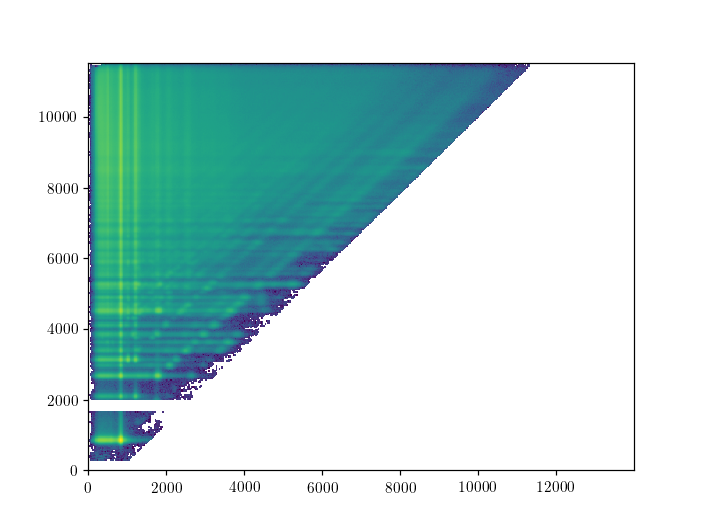

In [7]:
# Put it into an instance of om.MatrixAnalysis() to do unfolding and first generation method:
ma = om.MatrixAnalysis()
# ma.raw = raw
ma.raw = raw_rebinned
ma.raw.plot()

Hello from the fill_negative() function. Please debug me.


/home/jorgenem/gitrepos/oslo_method_python/oslo_method_python/unfold.py:271: RuntimeWarning: invalid value encountered in true_divide
  fluctuations_matrix = fluctuations_matrix/fluctuations_vector_raw[:,None] # TODO check that this broadcasts the vector over the right dimension


<IPython.core.display.Javascript object>


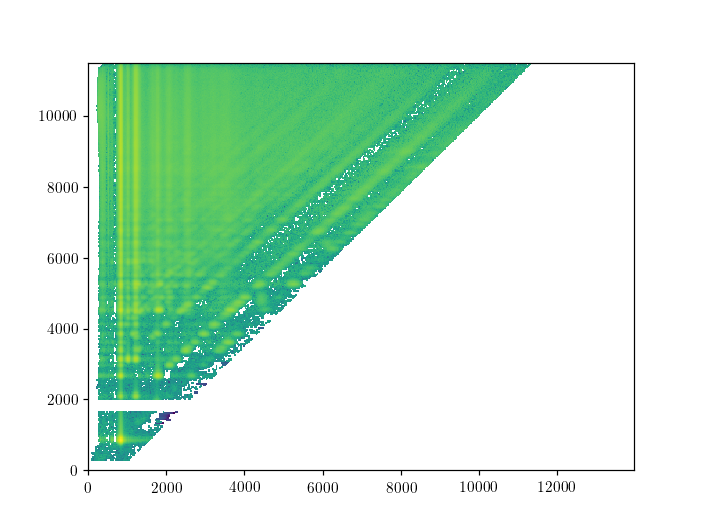

In [8]:
# Unfold the matrix. 
# I haven't implemented a fast enough routine for response function interpolation yet,
# so we have to load response functions with the right calibration, made by MAMA, from file.
fname_resp_mat = "data/response_matrix_20keV.m"
fname_resp_dat = "data/resp.dat"

# Call the unfolding algorithm:
diag_cut = {"Ex1": 0, "Eg1": 800, "Ex2": 7300, "Eg2": 7500}
ma.unfold(fname_resp_dat=fname_resp_dat, fname_resp_mat=fname_resp_mat, diag_cut=diag_cut,
          fill_and_remove_negative=True)
# The result is stored in the Matrix() instance ma.unfolded. Plot it:
ma.unfolded.plot()

Hello from the fill_negative() function. Please debug me.


<IPython.core.display.Javascript object>


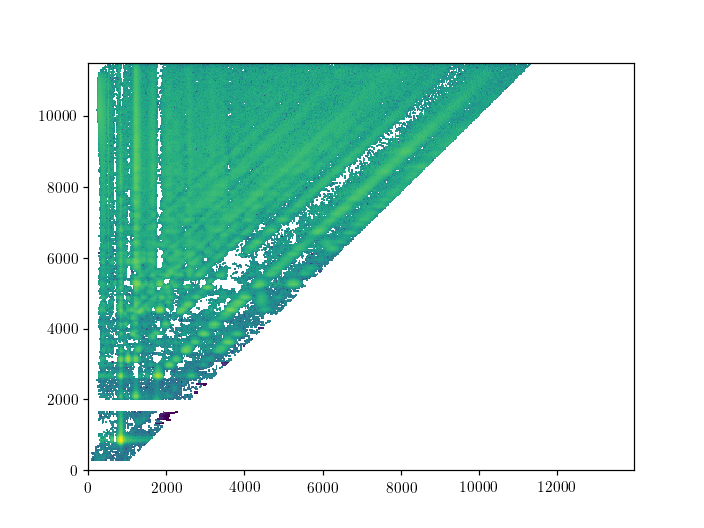

In [9]:
# Run first generation method
ma.first_generation_method(Ex_max = 11500, dE_gamma = 500,
                           fill_and_remove_negative=True)
ma.firstgen.plot(zmin=1e-3)

In [11]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
N_ensemble = 30
ep = om.ErrorPropagation(ma, folder="error_propagation_ensemble", random_seed=481516)
ep.generate_ensemble(N_ensemble_members=N_ensemble, randomness="poisson", purge_files=True)

=== Begin ensemble member  0  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix


/home/jorgenem/gitrepos/oslo_method_python/oslo_method_python/unfold.py:271: RuntimeWarning: invalid value encountered in true_divide
  fluctuations_matrix = fluctuations_matrix/fluctuations_vector_raw[:,None] # TODO check that this broadcasts the vector over the right dimension


=== Begin ensemble member  1  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  2  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  3  ===
Generating raw matrix
Unfolding matrix


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


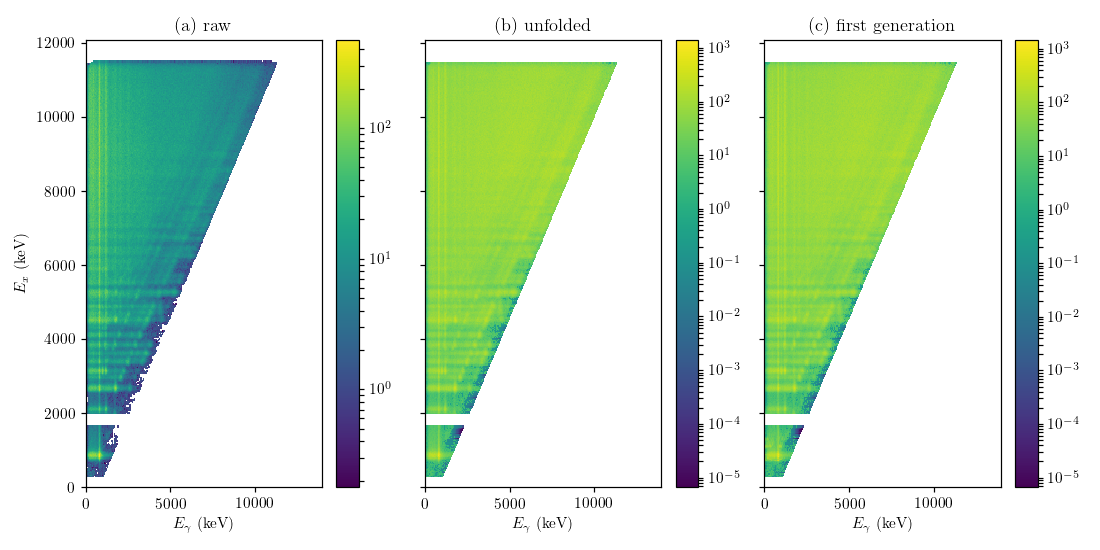

/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [13]:
f, (axraw, axunf, axfg) = plt.subplots(1, 3, sharey=True)

# Fetch and plot the standard deviation of raw:
std_raw = ep.std_raw
cbar_raw = std_raw.plot(ax=axraw)
f.colorbar(cbar_raw, ax=axraw)

# Fetch and plot the standard deviation of unfolded:
std_unfolded = ep.std_unfolded
cbar_unf = std_unfolded.plot(ax=axunf)
f.colorbar(cbar_unf, ax=axunf)

# Fetch and plot the standard deviation of firstgen:
std_firstgen = ep.std_firstgen
cbar_fg = std_firstgen.plot(ax=axfg)
f.colorbar(cbar_fg, ax=axfg)


# Add axis labels and titles
axraw.set_title("(a) raw")
axunf.set_title("(b) unfolded")
axfg.set_title("(c) first generation")

axraw.set_ylabel(r"$E_x \,\,\mathrm{(keV)}$")

axraw.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axunf.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")
axfg.set_xlabel(r"$E_\gamma \,\,\mathrm{(keV)}$")



f.set_size_inches((10, 5))
plt.tight_layout(True)


plt.savefig("Fe56-matrices_std_raw_unf_fg.png")

plt.show()

# Fit rho and T

attempt decomposition
Optimization terminated successfully.
         Current function value: 13482143.000000
         Iterations: 28
         Function evaluations: 23814


<IPython.core.display.Javascript object>


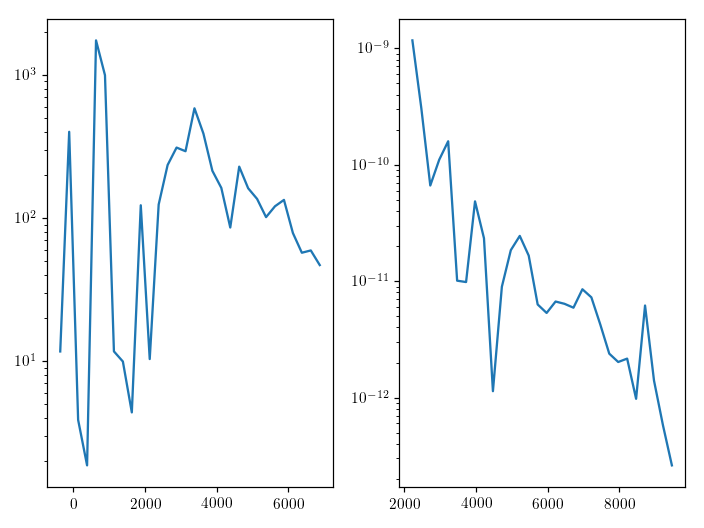

/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [26]:
bin_width_out = 300
Ex_min = 6600
Ex_max = 11300
Eg_min = 2100

ftol = 1e-5 # Fitting tolerance (in some unknown, relative units)
maxfev = None # maximum number of function evaluations

#rho, T = om.fit_rho_T(ma.firstgen, firstgen_std, bin_width_out,
fits = om.FitRhoT(ma.firstgen, std_firstgen, bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Powell",
                      options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                      #error_normalization="approximate"
                     )
fits.fit()
rho = fits.rho
T = fits.T


f, (axrho, axgsf) = plt.subplots(1,2)
rho.plot(ax=axrho, yscale="log")
#T.plot(ax=axT, yscale="log")
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, T.E_array**3))
gsf.plot(ax=axgsf, yscale="log")

plt.tight_layout(True)
plt.show()


<IPython.core.display.Javascript object>


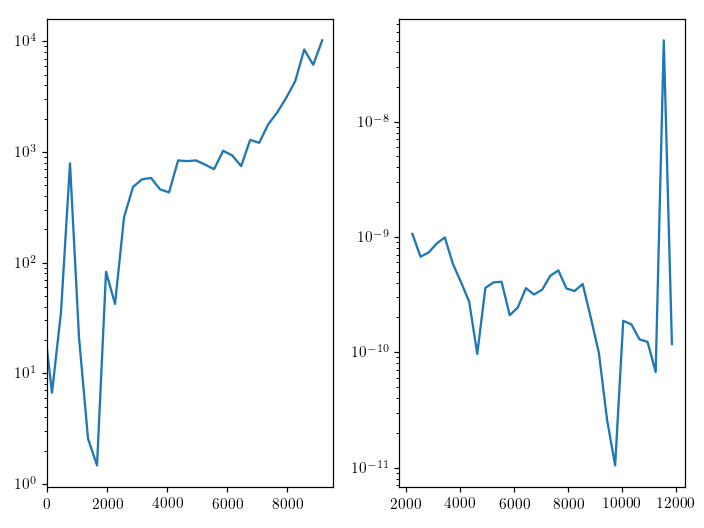

/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [16]:
# Play with alpha parameter
alpha = 0.0005

f, (axrho, axgsf) = plt.subplots(1,2)
rho.transform(alpha=alpha, inplace=False).plot(ax=axrho, yscale="log")
#T.plot(ax=axT, yscale="log")
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, T.E_array**3))
gsf.transform(alpha=alpha, inplace=False).plot(ax=axgsf, yscale="log")

axrho.set_xlim([0, rho.E_array.max()+500])

plt.tight_layout(True)
plt.show()

In [27]:
# Fit the whole error ensemble using their common error matrix; use spread as gauge for uncert
# We replace the firstgen matrix of "ma_curr" every iteration.
ma_curr = copy.deepcopy(ma)

N_ensemble_fit = 10
if N_ensemble_fit > N_ensemble:
    raise ValueError("Not enough ensemble members")
    
try:
    # Load ensemble members of rho and T fits
    rho_ens = np.loadtxt("error_propagation_ensemble/rho_ensemble_fits-Nens_{:d}-ftol_{:.0e}-Exmin_{:d}-Exmax_{:d}-bin_width_{:d}.txt".format(N_ensemble_fit, ftol, Ex_min, Ex_max, bin_width_out))
    T_ens = np.loadtxt("error_propagation_ensemble/T_ensemble_fits-Nens_{:d}-ftol_{:.0e}-Exmin_{:d}-Exmax_{:d}-bin_width_{:d}.txt".format(N_ensemble_fit, ftol, Ex_min, Ex_max, bin_width_out))

except:
    rho_ens = np.zeros((N_ensemble_fit, len(rho.vector)))
    T_ens = np.zeros((N_ensemble_fit, len(T.vector)))
    for i_ens in range(N_ensemble_fit):
        print("Fitting ensemble member {:d}".format(i_ens))
        ma_curr.firstgen.matrix = ep.firstgen_ensemble[i_ens, :, :]
        ma_curr.firstgen.matrix = om.fill_negative(ma_curr.firstgen.matrix, window_size=10)
        ma_curr.firstgen.matrix[ma_curr.firstgen.matrix < 0] = 0
        #ma.firstgen.plot()
        fits_curr = om.FitRhoT(ma_curr.firstgen, std_firstgen, bin_width_out,
                          Ex_min, Ex_max, Eg_min,
                          method="Powell",
                          options={'disp':True, 'ftol':ftol, 'maxfev':maxfev}
                         )
        fits_curr.fit()
        rho_curr= fits_curr.rho
        T_curr = fits_curr.T
        rho_ens[i_ens, :] = rho_curr.vector
        T_ens[i_ens, :] = T_curr.vector
    
    # Save ensemble members of rho and T fits

    np.savetxt("error_propagation_ensemble/rho_ensemble_fits-Nens_{:d}-ftol_{:.0e}-Exmin_{:d}-Exmax_{:d}-bin_width_{:d}.txt".format(N_ensemble_fit, ftol, Ex_min, Ex_max, bin_width_out),
               rho_ens)
    np.savetxt("error_propagation_ensemble/T_ensemble_fits-Nens_{:d}-ftol_{:.0e}-Exmin_{:d}-Exmax_{:d}-bin_width_{:d}.txt".format(N_ensemble_fit, ftol, Ex_min, Ex_max, bin_width_out),
               T_ens)

Fitting ensemble member 0
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 12133693.000000
         Iterations: 15
         Function evaluations: 12575
Fitting ensemble member 1
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 13119524.000000
         Iterations: 21
         Function evaluations: 18973
Fitting ensemble member 2
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 13798928.000000
         Iterations: 29
         Function evaluations: 24174
Fitting ensemble member 3
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 15018054.000000
         Iterations: 20
         Function eva

<IPython.core.display.Javascript object>


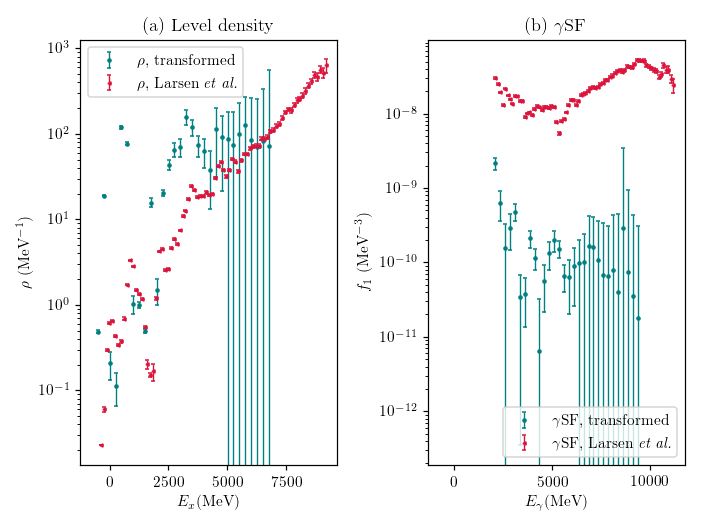

/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [30]:
# Plot with uncertainties, only the transformed versions
alpha=0.0005
A = 0.05
B = 2*np.pi*0.6

color="teal"

f, (axrho_transf, axgsf_transf) = plt.subplots(1, 2)

rho_std = om.Vector(vector=np.std(rho_ens, axis=0), E_array=rho.E_array)

axrho_transf.errorbar(rho.E_array, rho.transform(const=A, alpha=alpha).vector,
                      yerr=rho_std.transform(const=A, alpha=alpha).vector,
                      label=r"$\rho$, transformed", fmt="o", markersize=2, capsize=1,
                      linewidth=0.9, color=color)

# Load and add published, normalized data:
rho_published = np.loadtxt("data/nld_56Fe_FG05_NaI.txt", skiprows=2)
rho_published[:, 1] *= 1000
axrho_transf.errorbar(rho_published[:, 1], rho_published[:, 2], yerr=rho_published[:, 3],
                      fmt="<", markersize=2, color="crimson", linewidth=0.9,
                      label=r"$\rho$, Larsen $\textit{et\,\,al.}$")

#axrho_transf.set_title("rho, transformed")
axrho_transf.legend()
axrho_transf.set_yscale("log")

T_std = om.Vector(vector=np.std(T_ens, axis=0), E_array=T.E_array)

# Convert T to gsf
gsf = om.Vector(E_array=T.E_array, vector=om.div0(T.vector, 2*np.pi*T.E_array**3))
gsf_std = om.Vector(E_array=T_std.E_array, vector=om.div0(T_std.vector, 2*np.pi*T_std.E_array**3))



axgsf_transf.errorbar(gsf.E_array, gsf.transform(const=B, alpha=alpha).vector,
                      yerr=gsf_std.transform(const=B, alpha=alpha).vector,
                      label=r"$\gamma$SF, transformed", linewidth=0.9,
                      fmt="o", markersize=2, capsize=1, color=color)

# Load and add published, normalized data:
gsf_published = np.loadtxt("data/gsf_56Fe_FG05_NaI.txt", skiprows=2)
gsf_published[:, 1] *= 1000
axgsf_transf.errorbar(gsf_published[:, 1], gsf_published[:, 2], yerr=gsf_published[:, 3],
                      fmt="<", markersize=2, color="crimson", linewidth=0.9,
                      label=r"$\gamma$SF, Larsen $\textit{et\,\,al.}$")

#axgsf_transf.set_title("gsf, transformed")
axgsf_transf.legend()
axgsf_transf.set_yscale("log")

# Axis labels
axrho_transf.set_title("(a) Level density")
axgsf_transf.set_title(r"(b) $\gamma$SF")

axrho_transf.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
axgsf_transf.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")

axrho_transf.set_xlabel(r"$E_x (\mathrm{MeV})$")
axgsf_transf.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

plt.tight_layout(True)

f.savefig("Dy164_rho_and_T_fit_alpha_transform.pdf")

plt.show()

<IPython.core.display.Javascript object>


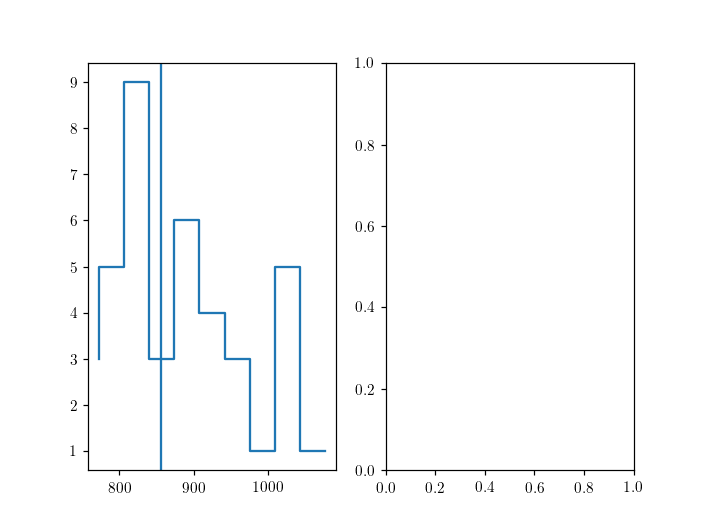

In [89]:
# Study histogram distribution of rho and gsf uncertainties in single energy bin
f, (axrho, axgsf) = plt.subplots(1, 2)


E_rho = 8200 # Which bin to select
i_rho = np.argmin(np.abs(E_rho - rho.E_array))

rho_E_array_midbin = rho.E_array + rho.calibration()["a1"]/2
values_rho = rho_ens[:, i_rho]*np.exp(alpha*rho_E_array_midbin[i_rho])
hist_rho, bins_rho = np.histogram(values_rho, bins=10)
axrho.step(bins_rho[:-1], hist_rho)
axrho.axvline(rho.vector[i_rho]*np.exp(alpha*rho_E_array_midbin[i_rho]))

plt.show()

<IPython.core.display.Javascript object>


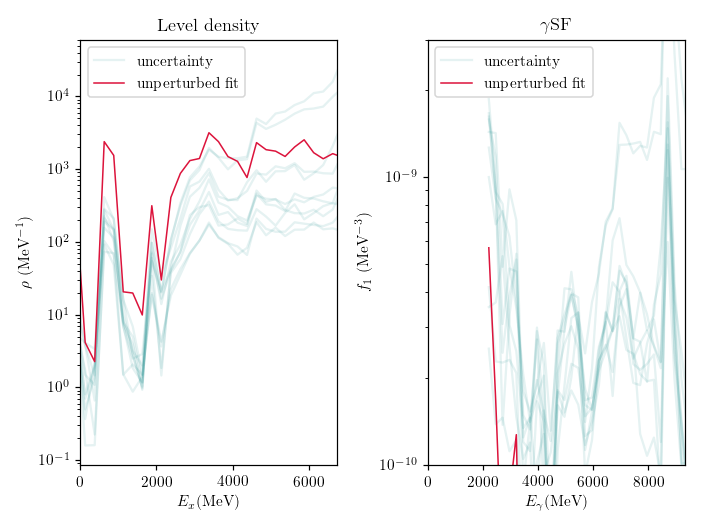

/home/jorgenem/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [29]:
# Plot rho and gsf ensembles

f, (axrho, axgsf) = plt.subplots(1, 2)

opacity = 0.1

# rho
rho_E_array_midbin = rho.E_array + rho.calibration()["a1"]/2
for i_ens in range(len(rho_ens[:, 0])):
    label = "uncertainty" if i_ens == 0 else None
    axrho.plot(rho_E_array_midbin, rho_ens[i_ens, :]*np.exp(alpha*rho_E_array_midbin), alpha=opacity,
               color="teal", label=label)
rho.transform(alpha=alpha).plot(ax=axrho, color="crimson", linewidth=1, label="unperturbed fit")

axrho.legend()
axrho.set_yscale("log")
axrho.set_xlim([0, rho.E_array.max()])
axrho.set_title("Level density")

# gsf
gsf_E_array_midbin = gsf.E_array + gsf.calibration()["a1"]/2
for i_ens in range(len(T_ens[:, 0])):
    label = "uncertainty" if i_ens == 0 else None
    axgsf.plot(gsf_E_array_midbin, T_ens[i_ens, :]*np.exp(alpha*gsf_E_array_midbin)/gsf_E_array_midbin**3,
               #alpha=opacity, color="teal", label=label, marker="s", markersize=0.8, linestyle="")
               alpha=opacity, color="teal", label=label)
gsf.transform(alpha=alpha).plot(ax=axgsf, color="crimson", linewidth=1, label="unperturbed fit")

axgsf.legend()
axgsf.set_yscale("log")
axgsf.set_xlim([0, gsf.E_array.max()])
axgsf.set_ylim([1e-10, 3e-9])
axgsf.set_title(r"$\gamma$SF")


# Axis labels
axrho.set_ylabel(r"$\rho \,\, (\mathrm{MeV}^{-1})$")
axgsf.set_ylabel(r"$f_1 \,\, (\mathrm{MeV}^{-3})$")
axrho.set_xlabel(r"$E_x (\mathrm{MeV})$")
axgsf.set_xlabel(r"$E_\gamma (\mathrm{MeV})$")

plt.tight_layout(True)
f.savefig("Fe56_fit_rho_gsf_transformed_with_uncertainty_band.pdf")

plt.show()